In [1]:
import zipfile
with zipfile.ZipFile('Archive.zip', 'r') as zip_ref:
    zip_ref.extractall('Archive')

In [1]:
import pandas as pd

accidents = pd.read_csv('Archive/Accidents.txt', sep='	', encoding='latin1', header=0)
users = pd.read_csv('Archive/Users.txt', sep='	', encoding='latin1', header=0)
vehicles = pd.read_csv('Archive/Vehicles.txt', sep='	', encoding='latin1', header=0)

/tmp/ipykernel_456560/3154385403.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#names of the columns
print(accidents.columns)
print(users.columns)
print(vehicles.columns)

Index(['AccidentId', 'Gravity', 'Date', 'Hour', 'Light', 'Department',
       'Commune', 'InAgglomeration', 'IntersectionType', 'Weather',
       'CollisionType', 'PostalAddress'],
      dtype='object')
Index(['AccidentId', 'VehicleId', 'Seat', 'Category', 'Gravity', 'Gender',
       'TripReason', 'SafetyDevice', 'SafetyDeviceUsed', 'PedestrianLocation',
       'PedestrianAction', 'PedestrianCompany', 'BirthYear'],
      dtype='object')
Index(['AccidentId', 'VehicleId', 'Direction', 'Category', 'PassengerNumber',
       'FixedObstacle', 'MobileObstacle', 'ImpactPoint', 'Maneuver'],
      dtype='object')


In [49]:
users['Category'].value_counts()

Category
Driver        96025
Passenger     23184
Pedestrian    10960
Name: count, dtype: int64

In [7]:
print(accidents.shape)
print(users.shape)
print(vehicles.shape)

(57783, 12)
(130169, 13)
(98876, 9)


In [2]:
#merge the data on AccidentId and VehicleId
users_vehicles = pd.merge(users, vehicles, on=['AccidentId', 'VehicleId'])


In [3]:
data = pd.merge(users_vehicles, accidents, on=['AccidentId'])
data = data.rename(columns={'Category_x': 'Category_user', 'Gravity_x': 'Gravity_user', 'Category_y': 'Category_vehicle', 'Gravity_y': 'Gravity_accident'})

In [4]:
data.columns

Index(['AccidentId', 'VehicleId', 'Seat', 'Category_user', 'Gravity_user',
       'Gender', 'TripReason', 'SafetyDevice', 'SafetyDeviceUsed',
       'PedestrianLocation', 'PedestrianAction', 'PedestrianCompany',
       'BirthYear', 'Direction', 'Category_vehicle', 'PassengerNumber',
       'FixedObstacle', 'MobileObstacle', 'ImpactPoint', 'Maneuver',
       'Gravity_accident', 'Date', 'Hour', 'Light', 'Department', 'Commune',
       'InAgglomeration', 'IntersectionType', 'Weather', 'CollisionType',
       'PostalAddress'],
      dtype='object')

In [5]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
data.columns

Index(['AccidentId', 'VehicleId', 'Seat', 'Category_user', 'Gravity_user',
       'Gender', 'TripReason', 'SafetyDevice', 'SafetyDeviceUsed',
       'PedestrianLocation', 'PedestrianAction', 'PedestrianCompany',
       'BirthYear', 'Direction', 'Category_vehicle', 'PassengerNumber',
       'FixedObstacle', 'MobileObstacle', 'ImpactPoint', 'Maneuver',
       'Gravity_accident', 'Date', 'Hour', 'Light', 'Department', 'Commune',
       'InAgglomeration', 'IntersectionType', 'Weather', 'CollisionType',
       'PostalAddress'],
      dtype='object')

In [9]:
print(data.dtypes[data.dtypes==object])

VehicleId             object
Category_user         object
Gravity_user          object
Gender                object
TripReason            object
SafetyDevice          object
SafetyDeviceUsed      object
PedestrianLocation    object
PedestrianAction      object
PedestrianCompany     object
Direction             object
Category_vehicle      object
FixedObstacle         object
MobileObstacle        object
ImpactPoint           object
Maneuver              object
Gravity_accident      object
Date                  object
Hour                  object
Light                 object
InAgglomeration       object
IntersectionType      object
Weather               object
CollisionType         object
PostalAddress         object
dtype: object


In [6]:
Y = accidents['Gravity']
X = accidents.drop(['Gravity','AccidentId','Date','Hour','Department','Commune','PostalAddress'], axis=1)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [17]:
cat_var = X_train.columns.values

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [18]:
Y_train

11265    NonLethal
21432    NonLethal
37727    NonLethal
53875    NonLethal
45483    NonLethal
           ...    
45891    NonLethal
52416    NonLethal
42613    NonLethal
43567    NonLethal
2732     NonLethal
Name: Gravity, Length: 40448, dtype: object

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [15]:
lb.classes_

array(['Lethal', 'NonLethal'], dtype='<U9')

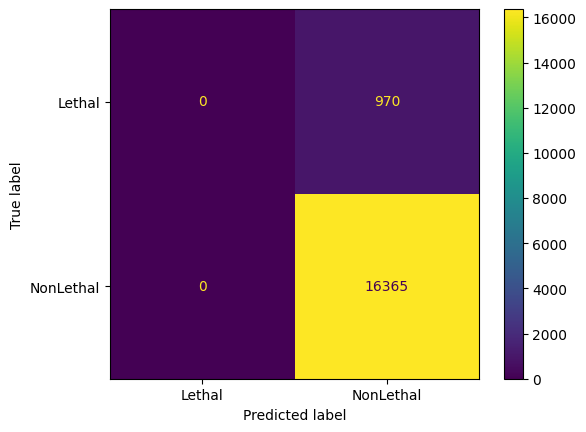

In [20]:
categorical_preprocessing = ColumnTransformer([
    ("OHE", OneHotEncoder(), cat_var)
])
    
model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", LogisticRegression(solver='lbfgs')),
])

model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
accuracy_score(Y_test, Y_hat)

cm = confusion_matrix(Y_test, Y_hat, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot()
plt.show()

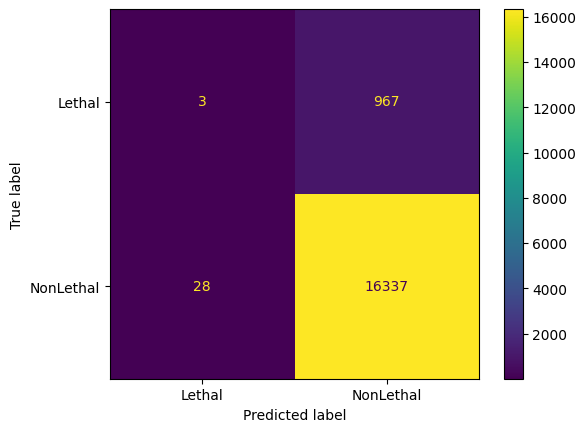

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", RandomForestClassifier(n_estimators=100)),
])

model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
accuracy_score(Y_test, Y_hat)

cm = confusion_matrix(Y_test, Y_hat, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot()
plt.show()

In [29]:
model.

Pipeline(steps=[('categorical preproc.',
                 ColumnTransformer(transformers=[('OHE', OneHotEncoder(),
                                                  array(['Light', 'InAgglomeration', 'IntersectionType', 'Weather',
       'CollisionType'], dtype=object))])),
                ('classifier', RandomForestClassifier())])

In [ ]:
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

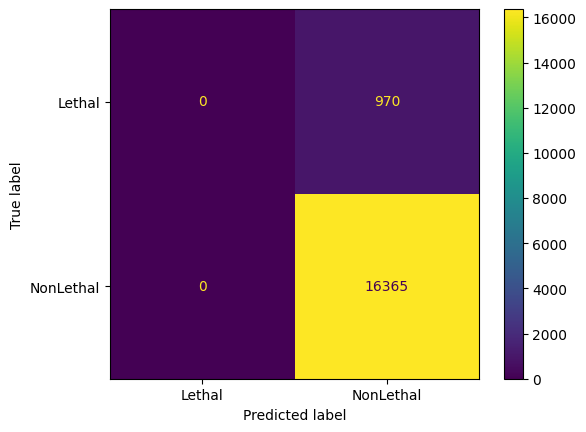

In [22]:
from sklearn import svm

model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", svm.SVC(kernel='linear')),
])

model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
accuracy_score(Y_test, Y_hat)

cm = confusion_matrix(Y_test, Y_hat, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot()
plt.show()

In [25]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y_train_2 = lb.fit_transform(Y_train)
Y_test_2 = lb.transform(Y_test)

In [26]:
import xgboost as xgb

model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", xgb.XGBClassifier()),
])

model.fit(X_train, Y_train_2)
Y_hat = model.predict(X_test)
accuracy_score(Y_test_2, Y_hat)

cm = confusion_matrix(Y_test, Y_hat, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot()
plt.show()

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['Lethal' 'NonLethal'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

In [63]:
data2 = data[data['Category_user'] == 'Driver']
Y = data2['Gravity_accident']
X = data2[['Gender', 'TripReason',
       'BirthYear']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

cat_var = ['Gender', 'TripReason']

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [64]:
categorical_preprocessing = ColumnTransformer([
    ("OHE", OneHotEncoder(), cat_var)
])
    
model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", LogisticRegression(solver='lbfgs')),
])

model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
f(Y_test, Y_hat)

/home/mverlynde/miniconda3/envs/hack_orange/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.948729519577895

In [66]:
accidents['Gravity'].value_counts()

Gravity
NonLethal    54597
Lethal        3186
Name: count, dtype: int64

In [68]:
import numpy as np
from sklearn.model_selection import cross_val_score

data2 = data[data['Category_user'] == 'Driver']
Y = data2['Gravity_accident']
X = data2[['Gender', 'TripReason',
       'BirthYear']]

cat_var = ['Gender', 'TripReason']

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

categorical_preprocessing = ColumnTransformer([
    ("OHE", OneHotEncoder(), cat_var)
])
    
model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", LogisticRegression(solver='lbfgs')),
])

print(np.mean(cross_val_score(model, X, Y, cv=10)))

0.9482114047667402


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import svm

Y = data2['Gravity_accident']
X = data2[['Gender', 'TripReason',
       'BirthYear']]

cat_var = ['Gender', 'TripReason']

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

categorical_preprocessing = ColumnTransformer([
    ("OHE", OneHotEncoder(), cat_var)
])
    
model = Pipeline([
    ("categorical preproc.", categorical_preprocessing),
    ("classifier", svm.SVC(kernel='linear'),
])

print(np.mean(cross_val_score(model, X, Y, cv=10)))

In [11]:
accidents.columns

Index(['AccidentId', 'Gravity', 'Date', 'Hour', 'Light', 'Department',
       'Commune', 'InAgglomeration', 'IntersectionType', 'Weather',
       'CollisionType', 'PostalAddress'],
      dtype='object')

In [12]:
g = sns.PairGrid(accidents.drop(['AccidentId'], axis=1), hue="Gravity", vars=['Gravity', 'Date', 'Hour', 'Light', 'Department',
       'Commune', 'InAgglomeration', 'IntersectionType', 'Weather',
       'CollisionType', 'PostalAddress'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
g.add_legend()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8ee5f5cc10>>
Traceback (most recent call last):
  File "/home/mverlynde/miniconda3/envs/hack_orange/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
